Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022  
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Stroj potpornih vektora

*Verzija: 1.0 
Zadnji put ažurirano: 1. listopada 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **21. studenog 2021. u 23:59h**  

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import mlutils
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_2d_svc_problem(X, y, svc=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if SVC object is given, 
    the decision surfaces (with margin as well).
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if svc!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        Z = np.array([svc_predict(svc, x) for x in XX])
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.Paired, marker='o', s=50)

def svc_predict(svc, x) : 
    h = svc.decision_function([x])
    if np.isclose(h, 0, atol=0.03):
        return 5
    elif (h >= -1 and h < -0.03) or (h > 0.03 and h <= 1):
        return 0.5
    else: 
        return max(-1, min(1, h))
    
def plot_error_surface(err, c_range=(0,5), g_range=(0,5)):
    c1, c2 = c_range[0], c_range[1]
    g1, g2 = g_range[0], g_range[1]
    plt.xticks(range(0,g2-g1+1,5),range(g1,g2+1,5)); plt.xlabel("gamma")
    plt.yticks(range(0,c2-c1+1,5),range(c1,c2+1,5)); plt.ylabel("C")
    p = plt.contour(err);
    plt.imshow(1-err, interpolation='bilinear', origin='lower',cmap=plt.cm.gray)
    plt.clabel(p, inline=1, fontsize=10)
    

### 1. Klasifikator stroja potpornih vektora (SVM)

#### (a)

Upoznajte se s razredom [`svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), koja ustvari implementira sučelje prema implementaciji [`libsvm`](http://www.csie.ntu.edu.tw/~cjlin/libsvm/). Primijenite model `SVC` s linearnom jezgrenom funkcijom (tj. bez preslikavanja primjera u prostor značajki) na skup podataka `seven` (dan niže) s $N=7$ primjera. Ispišite koeficijente $w_0$ i $\mathbf{w}$. Ispišite dualne koeficijente i potporne vektore. Završno, koristeći funkciju `plot_2d_svc_problem` iscrtajte podatke, decizijsku granicu i marginu. Funkcija prima podatke, oznake i klasifikator (objekt klase `SVC`). 

In [3]:
from sklearn.svm import SVC

seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, -1, -1, -1])

w0: [3.99951172]
w: [[-9.99707031e-01 -2.92968750e-04]]
dual: [[-4.99707031e-01 -1.46484375e-04  4.99853516e-01]]
support vectors:
[[5. 2.]
 [5. 4.]
 [3. 2.]]


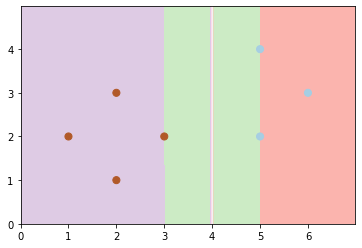

In [4]:
svc = SVC(kernel="linear")
model = svc.fit(seven_X, seven_y)

# weights
w0 = model.intercept_
w = model.coef_
print(f"w0: {w0}")
print(f"w: {w}")

dual = model.dual_coef_
print(f"dual: {dual}")

vectors = model.support_vectors_
print(f"support vectors:\n{vectors}")

# show chart
plot_2d_svc_problem(seven_X, seven_y, model)

**Q:** Koji primjeri su potporni vektori i zašto?

#### (b)

Definirajte funkciju `hinge(model, x, y)` koja izračunava gubitak zglobnice modela SVM na primjeru `x`. Izračunajte gubitke modela naučenog na skupu `seven` za primjere $\mathbf{x}^{(2)}=(3,2)$ i $\mathbf{x}^{(1)}=(3.5,2)$ koji su označeni pozitivno ($y=1$) te za $\mathbf{x}^{(3)}=(4,2)$ koji je označen negativno ($y=-1$). Također, izračunajte prosječni gubitak SVM-a na skupu `seven`. Uvjerite se da je rezultat identičan onome koji biste dobili primjenom ugrađene funkcije [`metrics.hinge_loss`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html).

In [5]:
from sklearn.metrics import hinge_loss

X2 = np.array([[3, 2], [3.5, 2], [4, 2]])
y2 = np.array([1, 1, -1])


def hinge(model, x, y):
    L = max(0, 1 - y * model.decision_function(x))
    return L
    

# loss
for x, y in zip(X2, y2):
    L = hinge(model, x.reshape(1, -1), y)
    print(f"L = {L[0]}")

# average loss
avg_loss = 0
for x, y in zip(seven_X, seven_y):
    L = hinge(model, x.reshape(1, -1), y)
    avg_loss += L
avg_loss /= len(seven_X)
print(f"average loss: {avg_loss[0]}")

# stock hinge loss
predicted_y = model.decision_function(seven_X)
L = hinge_loss(y_true=seven_y, pred_decision=predicted_y)
print(f"hinge loss: {L}")

assert(avg_loss == L)

L = 0.00019531249999893419
L = 0.5000488281249984
L = 1.0000976562500012
average loss: 8.37053571429079e-05
hinge loss: 8.37053571429079e-05


#### (c)

Vratit ćemo se na skupove podataka `outlier` ($N=8$) i `unsep` ($N=8$) iz prošle laboratorijske vježbe (dani niže) i pogledati kako se model SVM-a nosi s njima. Naučite ugrađeni model SVM-a (s linearnom jezgrom) na ovim podatcima i iscrtajte decizijsku granicu (skupa s marginom). Također ispišite točnost modela korištenjem funkcije [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

In [6]:
from sklearn.metrics import accuracy_score

outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, -1)

unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, -1)

score: 1.0


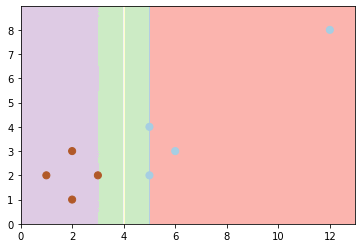

In [7]:
# outlier
svc = SVC(kernel="linear")
model = svc.fit(outlier_X, outlier_y)

# show chart
plot_2d_svc_problem(outlier_X, outlier_y, model)

y_predicted = model.predict(outlier_X)
score = accuracy_score(y_true=outlier_y, y_pred=y_predicted)
print(f"score: {score}")

assert(score == 1)

**Q:** Kako stršeća vrijednost utječe na SVM?  
**Q:** Kako se linearan SVM nosi s linearno neodvojivim skupom podataka?

score: 0.875


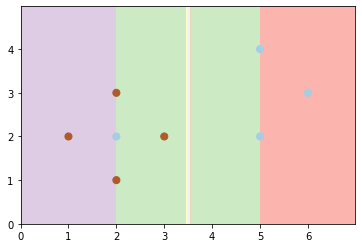

In [8]:
# unsep
svc = SVC(kernel="linear")
model = svc.fit(unsep_X, unsep_y)

# show chart
plot_2d_svc_problem(unsep_X, unsep_y, model)

y_predicted = model.predict(unsep_X)
score = accuracy_score(y_true=unsep_y, y_pred=y_predicted)
print(f"score: {score}")

assert(score < 1)

### 2. Nelinearan SVM

Ovaj zadatak pokazat će kako odabir jezgre utječe na kapacitet SVM-a. Na skupu `unsep` iz prošlog zadatka trenirajte tri modela SVM-a s različitim jezgrenim funkcijama: linearnom, polinomijalnom i radijalnom baznom (RBF) funkcijom. Varirajte hiperparametar $C$ po vrijednostima $C\in\{10^{-2},1,10^2\}$, dok za ostale hiperparametre (stupanj polinoma za polinomijalnu jezgru odnosno hiperparametar $\gamma$ za jezgru RBF) koristite podrazumijevane vrijednosti. Prikažite granice između klasa (i margine) na grafikonu organiziranome u polje $3x3$, gdje su stupci različite jezgre, a retci različite vrijednosti parametra $C$.

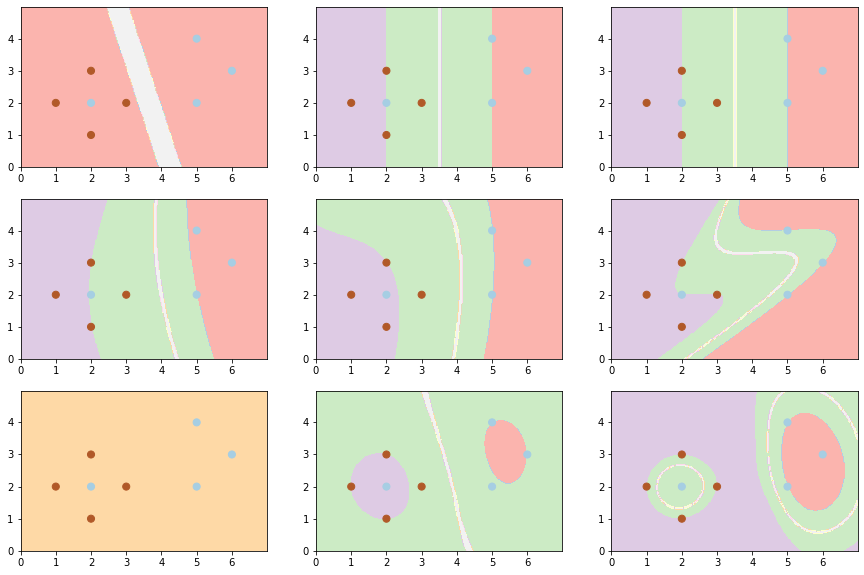

In [9]:
kernel_list = ["linear", "poly", "rbf"]
C_list = [10**(-2), 1, 10**2]

# prepare plot
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
plot_num = 1

for kernel in kernel_list:
    for C in C_list:
        svc = SVC(C=C, kernel=kernel)
        model = svc.fit(unsep_X, unsep_y)

        # show chart
        plt.subplot(3, 3, plot_num)
        plot_2d_svc_problem(unsep_X, unsep_y, model)
        plot_num += 1

### 3. Optimizacija hiperparametara SVM-a

Pored hiperparametra $C$, model SVM s jezgrenom funkcijom RBF ima i dodatni hiperparametar $\gamma=\frac{1}{2\sigma^2}$ (preciznost). Taj parametar također određuje složenost modela: velika vrijednost za $\gamma$ znači da će RBF biti uska, primjeri će biti preslikani u prostor u kojem su (prema skalarnome produktu) međusobno vrlo različiti, što će rezultirati složenijim modelima. Obrnuto, mala vrijednost za $\gamma$ znači da će RBF biti široka, primjeri će biti međusobno sličniji, što će rezultirati jednostavnijim modelima. To ujedno znači da, ako odabremo veći $\gamma$, trebamo jače regularizirati model, tj. trebamo odabrati manji $C$, kako bismo spriječili prenaučenost. Zbog toga je potrebno zajednički optimirati hiperparametre $C$ i $\gamma$, što se tipično radi iscrpnim pretraživanjem po rešetci (engl. *grid search*). Ovakav pristup primjenjuje se kod svih modela koji sadrže više od jednog hiperparametra.


#### (a)

Definirajte funkciju 

> `grid_search(X_train, X_validate, y_train, y_validate, c_range=(c1,c2), g_range=(g1,g2), error_surface=False)` 

koja optimizira parametre $C$ i $\gamma$ pretraživanjem po rešetci. Funkcija treba pretražiti hiperparametre $C\in\{2^{c_1},2^{c_1+1},\dots,2^{c_2}\}$ i $\gamma\in\{2^{g_1},2^{g_1+1},\dots,2^{g_2}\}$. Funkcija treba vratiti optimalne hiperparametre $(C^*,\gamma^*)$, tj. one za koje na skupu za provjeru model ostvaruju najmanju pogrešku. Dodatno, ako je `surface=True`, funkcija treba vratiti matrice (tipa `ndarray`) pogreške modela (očekivanje gubitka 0-1) na skupu za učenje i skupu za provjeru. Svaka je matrica dimenzija $(c_2-c_1+1)\times(g_2-g_1+1)$ (retci odgovaraju različitim vrijednostima za $C$, a stupci različitim vrijednostima za $\gamma$).

In [10]:
from sklearn.metrics import accuracy_score, zero_one_loss

"""
def grid_search(X_train, X_validate, y_train, y_validate, c_range=(0,5), g_range=(0,5), error_surface=False):
    # make more readable
    c1 = c_range[0]
    c2 = c_range[1]
    g1 = g_range[0]
    g2 = g_range[1]
    
    # create range lists
    C_list = [2**i for i in range(c1, c2+1)]
    gamma_list = [2**i for i in range(g1, g2+1)]
    
    C_optimal = C_list[0]
    gamma_optimal = gamma_list[0]

    error_train_trace = np.zeros((c2-c1+1, g2-g1+1))
    error_test_trace = np.zeros((c2-c1+1, g2-g1+1))
    error_test_min = -1

    for C_index in range(len(C_list)):
        for gamma_index in range(len(gamma_list)):
            C = C_list[C_index]
            gamma = gamma_list[gamma_index]
            
            # model
            svc = SVC(C=C, gamma=gamma)
            model = svc.fit(X_train, y_train)
            
            # train model
            h_train = model.predict(X_train)
            h_validate = model.predict(X_validate)
            
            error_train = zero_one_loss(y_true=y_train, y_pred=h_train)
            error_test = zero_one_loss(y_true=y_validate, y_pred=h_validate)
            
            # surface
            error_train_trace[C_index][gamma_index] = error_train
            error_test_trace[C_index][gamma_index] = error_test
            
            # validate optimal params
            if error_test_min == -1 or error_test < error_test_min:
                error_test_min = error_test
                C_optimal = C
                gamma_optimal = gamma
                
    if error_surface:
        return C_optimal, gamma_optimal, error_train_trace, error_test_trace
    else:
        return C_optimal, gamma_optimal
        
"""


def grid_search(X_train, X_validate, y_train, y_validate, c_range=(0,5), g_range=(0,5), error_surface=False):
    c1 = c_range[0]
    c2 = c_range[1]
    g1 = g_range[0]
    g2 = g_range[1]
    c1c2 = []; g1g2 = [];
    for i in range(0, c2-c1+1):
        c1c2.append(c1+i)
    for i in range(0, g2-g1+1):
        g1g2.append(g1+i)
        
    C = []; gamma = [];
    for i in c1c2:
        C.append(2**i)
    for i in g1g2:
        gamma.append(2**i)
        
    err_train = 0; err_valid = 0; err_min = inf; 
    C_opt = 0; gamma_opt = 0;
    err_tr_ret = np.zeros(((c2-c1+1), (g2-g1+1)));
    err_val_ret = np.zeros(((c2-c1+1), (g2-g1+1)));
    
    for i in C:
        for j in gamma:
            
            model = SVC(C = i, gamma = j).fit(X_train, y_train)
            h_tr = model.predict(X_train)
            h_val = model.predict(X_validate)
            
            err_train = zero_one_loss(y_train, h_tr)
            err_valid = zero_one_loss(y_validate, h_val)
            
            if err_valid < err_min:
                err_min = err_valid
                C_opt = i
                gamma_opt = j
                
            err_tr_ret[C.index(i)][gamma.index(j)] = err_train
            err_val_ret[C.index(i)][gamma.index(j)] = err_valid
                
    
    if error_surface:
        return C_opt, gamma_opt, err_tr_ret, err_val_ret
    else:
        return C_opt, gamma_opt


#### (b)

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte **dva** skupa podataka od $N=200$ primjera: jedan s $n=2$ dimenzije i drugi s $n=100$ dimenzija. Primjeri neka dolaze iz dviju klasa, s time da svakoj klasi odgovaraju dvije grupe (`n_clusters_per_class=2`), kako bi problem bio nešto složeniji, tj. nelinearniji. Neka sve značajke budu informativne. Podijelite skup primjera na skup za učenje i skup za ispitivanje u omjeru 1:1.

Na oba skupa optimirajte SVM s jezgrenom funkcijom RBF, u rešetci $C\in\{2^{-5},2^{-4},\dots,2^{15}\}$ i $\gamma\in\{2^{-15},2^{-14},\dots,2^{3}\}$. Prikažite površinu pogreške modela na skupu za učenje i skupu za provjeru, i to na oba skupa podataka (ukupno četiri grafikona) te ispišite optimalne kombinacije hiperparametara. Za prikaz površine pogreške modela možete koristiti funkciju `mlutils.plot_error_surface`.

In [11]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X2, y2 = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, n_classes=2, n_clusters_per_class=2)
X100, y100 = make_classification(n_samples=200, n_features=100, n_informative=100, n_redundant=0, n_classes=2, n_clusters_per_class=2)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5)
X100_train, X100_test, y100_train, y100_test = train_test_split(X100, y100, test_size=0.5)

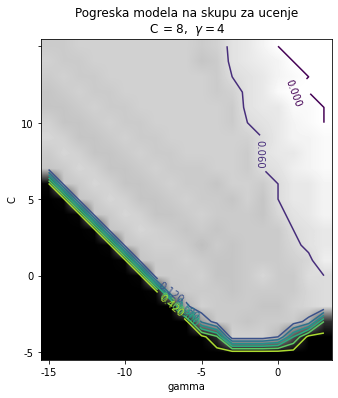

In [12]:


[C1_opt, g1_opt, tr_err1, val_err1] = grid_search(X2_train, X2_test, y2_train, y2_test, (-5,15), (-15,3), error_surface= True)

"""
C_optimal, gamma_optimal, error_train_trace, error_test_trace = grid_search(X2_train, X2_test, y2_train, y2_test, c_range=(-5,15), g_range=(-15,3), error_surface=True)
mlutils.plot_error_surface(error_train_trace, c_range=(-5,15),  g_range=(-15,3))
"""

figure(figsize(12, 13))
subplots_adjust(wspace=0.01, hspace = 0.2) 
subplot(2,2,1)
mlutils.plot_error_surface(tr_err1, (-5,15), (-15,3))
title('Pogreska modela na skupu za ucenje' + '\n C = ' + str(C1_opt) + ',  $\gamma = $' + str(g1_opt));

/home/satan/DEV/machine-learning-1/mlutils.py:169: UserWarning: No contour levels were found within the data range.
  p = plt.contour(err);


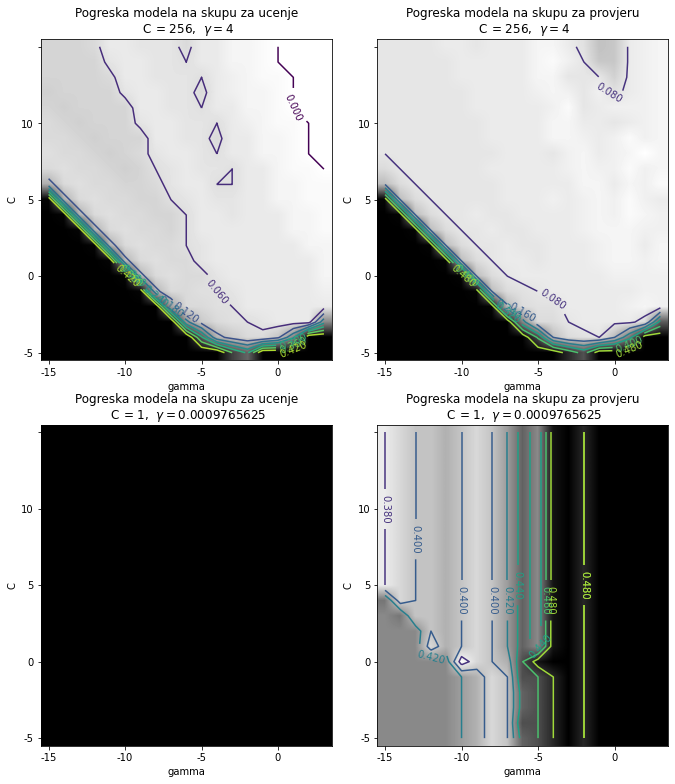

In [13]:


from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split as TTS



[X31, y31] = make_classification(n_samples=200, n_features=2, n_informative=2 , n_redundant=0, n_classes=2, n_clusters_per_class=2)
X31_train, X31_validate, y31_train, y31_validate = TTS(X31, y31, test_size = 0.5)

[X32, y32] = make_classification(n_samples=200, n_features=1000, n_informative=2, n_redundant=0, n_classes=2, n_clusters_per_class=2)
X32_train, X32_validate, y32_train, y32_validate = TTS(X32, y32, test_size = 0.5)

[C1_opt, g1_opt, tr_err1, val_err1] = grid_search(X31_train, X31_validate, y31_train, y31_validate, (-5,15), (-15,3), error_surface= True)
[C2_opt, g2_opt, tr_err2, val_err2] = grid_search(X32_train, X32_validate, y32_train, y32_validate, (-5,15), (-15,3), error_surface= True)

figure(figsize(12, 13))
subplots_adjust(wspace=0.01, hspace = 0.2) 
subplot(2,2,1)
mlutils.plot_error_surface(tr_err1, (-5,15), (-15,3))
title('Pogreska modela na skupu za ucenje' + '\n C = ' + str(C1_opt) + ',  $\gamma = $' + str(g1_opt));

subplot(2,2,2)
mlutils.plot_error_surface(val_err1, (-5,15), (-15,3))
title('Pogreska modela na skupu za provjeru' + '\n C = ' + str(C1_opt) + ',  $\gamma = $' + str(g1_opt));

subplot(2,2,3)
mlutils.plot_error_surface(tr_err2, (-5,15), (-15,3))
title('Pogreska modela na skupu za ucenje' + '\n C = ' + str(C2_opt) + ',  $\gamma = $' + str(g2_opt));

subplot(2,2,4)
mlutils.plot_error_surface(val_err2, (-5,15), (-15,3))
title('Pogreska modela na skupu za provjeru' + '\n C = ' + str(C2_opt) + ',  $\gamma = $' + str(g2_opt));

**Q:** Razlikuje li se površina pogreške na skupu za učenje i skupu za ispitivanje? Zašto?  
**Q:** U prikazu površine pogreške, koji dio površine odgovara prenaučenosti, a koji podnaučenosti? Zašto?  
**Q:** Kako broj dimenzija $n$ utječe na površinu pogreške, odnosno na optimalne hiperparametre $(C^*, \gamma^*)$?  
**Q:** Preporuka je da povećanje vrijednosti za $\gamma$ treba biti popraćeno smanjenjem vrijednosti za $C$. Govore li vaši rezultati u prilog toj preporuci? Obrazložite.  

### 4. Utjecaj standardizacije značajki kod SVM-a

Iz laboratorijske vježbe na temu regresije, sjećamo se da značajke različitih skala mogu onemogućiti interpretaciju naučenog modela linearne regresije. Međutim, ovaj problem javlja se kod mnogih modela pa je tako skoro uvijek bitno prije treniranja skalirati značajke, kako bi se spriječilo da značajke s većim numeričkim rasponima dominiraju nad onima s manjim numeričkim rasponima. To vrijedi i za SVM, kod kojega skaliranje nerijetko može znatno poboljšati rezultate. Svrha ovog zadataka jest eksperimentalno utvrditi utjecaj skaliranja značajki na točnost SVM-a.

Generirat ćemo dvoklasni skup od $N=500$ primjera s $n=2$ značajke, tako da je dimenzija $x_1$ većeg iznosa i većeg raspona od dimenzije $x_0$, te ćemo dodati jedan primjer koji vrijednošću značajke $x_1$ odskače od ostalih primjera:

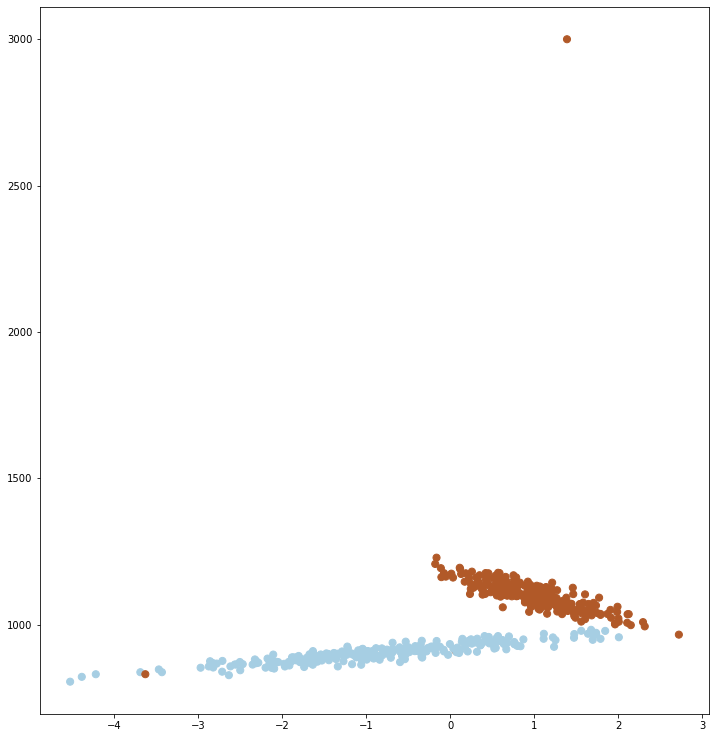

In [42]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500,n_features=2,n_classes=2,n_redundant=0,n_clusters_per_class=1, random_state=69)
X[:,1] = X[:,1]*100+1000
X[0,1] = 3000

plot_2d_svc_problem(X, y)

#### (a)

Proučite funkciju za iscrtavanje histograma [`hist`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hist). Prikažite histograme vrijednosti značajki $x_0$ i $x_1$ (ovdje i u sljedećim zadatcima koristite `bins=50`).

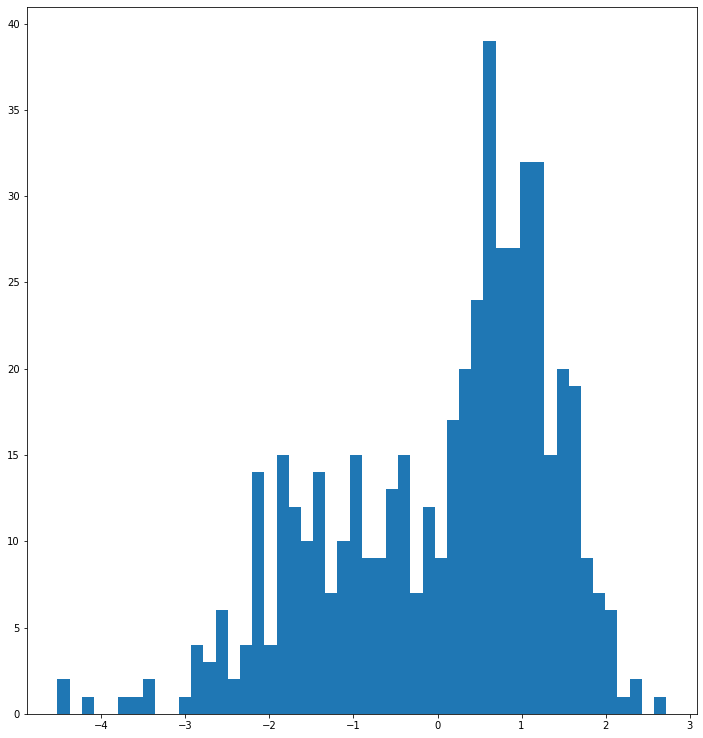

In [41]:
X0 = X[:, 0]
plt.hist(X0, bins=50)
plt.show()

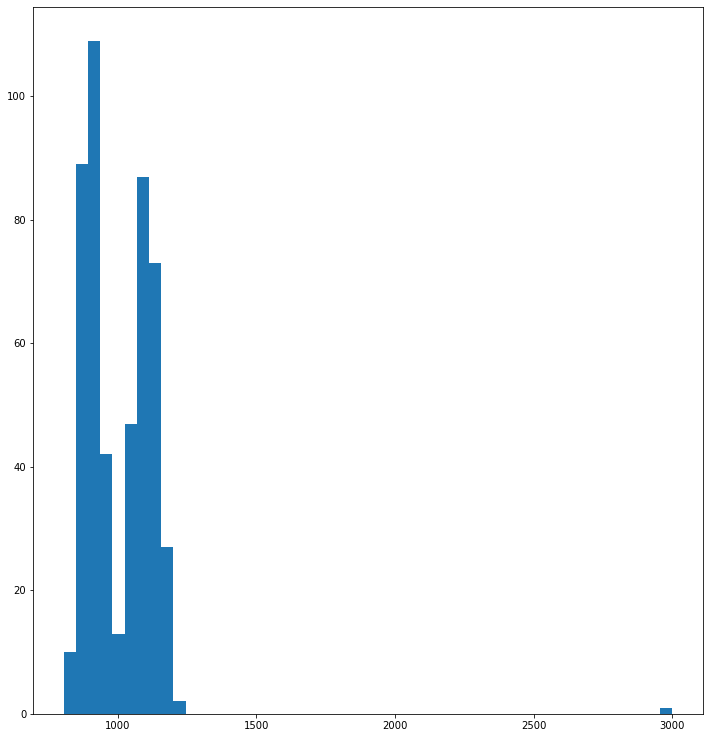

In [40]:
X1 = X[:, 1]
plt.hist(X1, bins=50)
plt.show()

#### (b)

Proučite razred [`preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). Prikažite histograme vrijednosti značajki $x_0$ i $x_1$ ako su iste skalirane min-max skaliranjem (ukupno dva histograma).

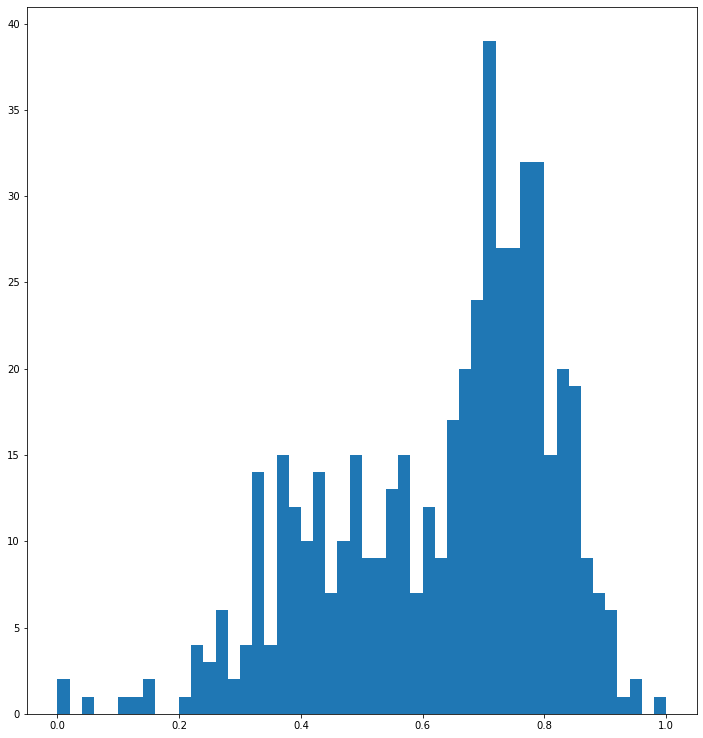

In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X0_scaled = scaler.fit_transform(X0.reshape(-1, 1), y)

plt.hist(X0_scaled, bins=50)
plt.show()

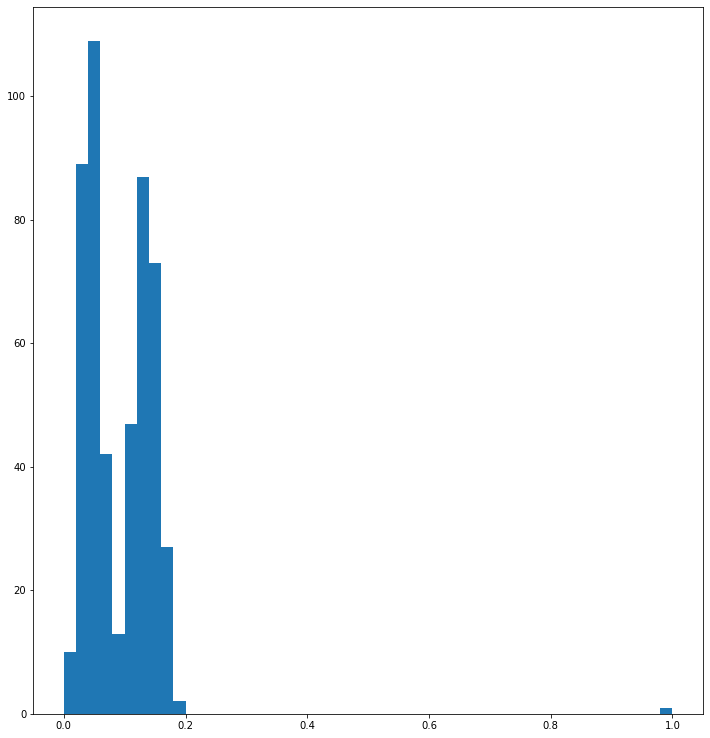

In [38]:
scaler = MinMaxScaler()
X1_scaled = scaler.fit_transform(X1.reshape(-1, 1), y)

plt.hist(X1_scaled, bins=50)
plt.show()

**Q:** Kako radi ovo skaliranje? <br>
**Q:** Dobiveni histogrami su vrlo slični. U čemu je razlika? <br>

#### (c)

Proučite razred [`preprocessing.StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Prikažite histograme vrijednosti značajki $x_0$ i $x_1$ ako su iste skalirane standardnim skaliranjem (ukupno dva histograma).

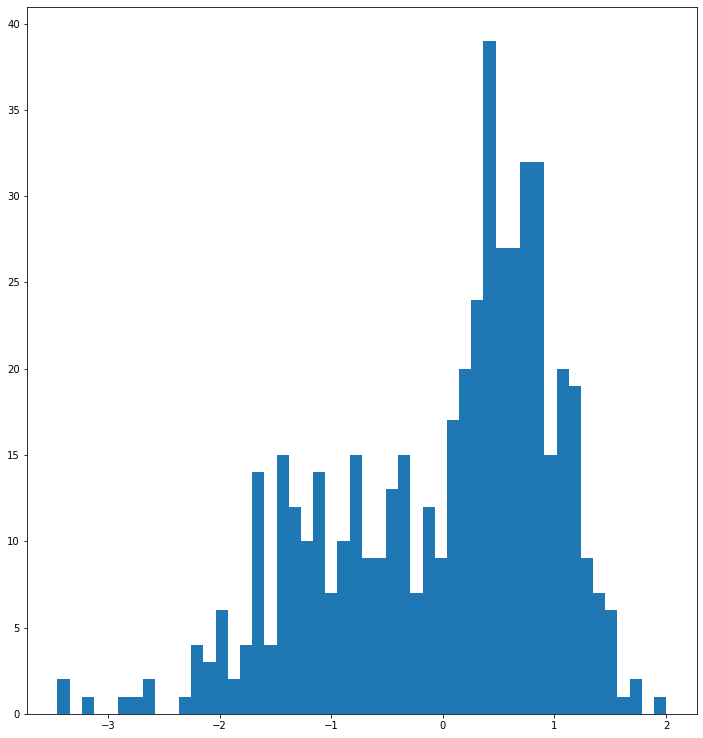

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X0_scaled2 = scaler.fit_transform(X0.reshape(-1, 1), y)

plt.hist(X0_scaled2, bins=50)
plt.show()

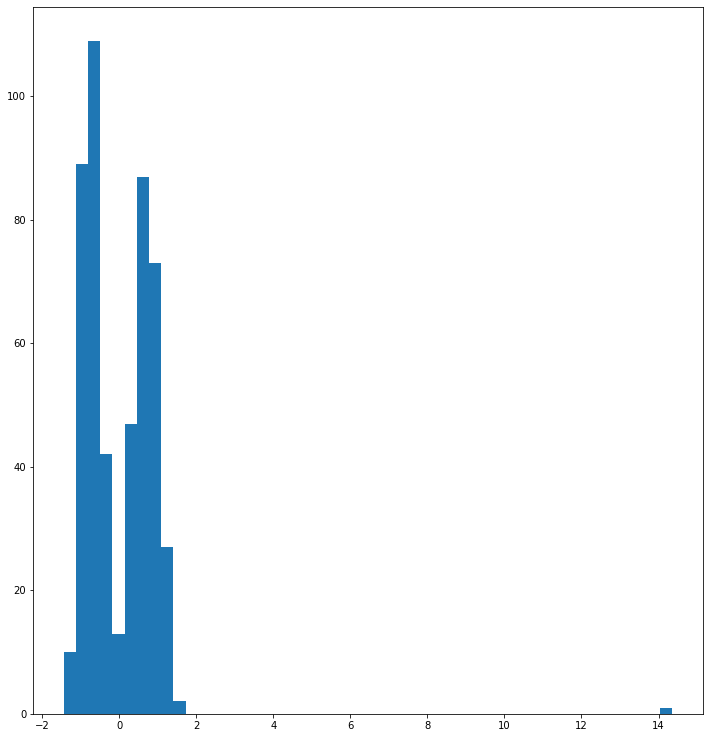

In [36]:
scaler = StandardScaler()
X1_scaled2 = scaler.fit_transform(X1.reshape(-1, 1), y)

plt.hist(X1_scaled2, bins=50)
plt.show()

**Q:** Kako radi ovo skaliranje? <br>
**Q:** Dobiveni histogrami su vrlo slični. U čemu je razlika? <br>

#### (d)

Podijelite skup primjera na skup za učenje i skup za ispitivanje u omjeru 1:1. Trenirajte SVM s jezgrenom funkcijom RBF na skupu za učenje i ispitajte točnost modela na skupu za ispitivanje, koristeći tri varijante gornjeg skupa: neskalirane značajke, standardizirane značajke i min-max skaliranje. Koristite podrazumijevane vrijednosti za $C$ i $\gamma$. Izmjerite točnost svakog od triju modela na skupu za učenje i skupu za ispitivanje. Ponovite postupak više puta (npr. 30) te uprosječite rezultate (u svakom ponavljanju generirajte podatke kao što je dano na početku ovog zadatka).

**NB:** Na skupu za učenje treba najprije izračunati parametre skaliranja te zatim primijeniti skaliranje (funkcija `fit_transform`), dok na skupu za ispitivanje treba samo primijeniti skaliranje s parametrima koji su dobiveni na skupu za učenje (funkcija `transform`).

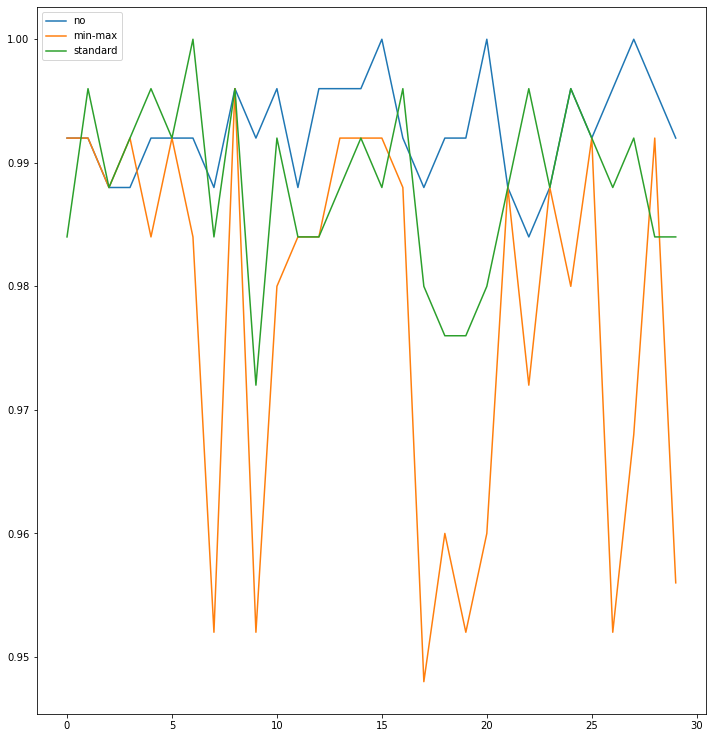

Average no scale: 0.9926666666666666
Average min-max scale: 0.9781333333333335
Average standard scale: 0.9881333333333333


In [35]:
iterations = 30

error_no_scaled_list = list()
error_min_max_scaled_list = list()
error_standard_scaled_list = list()

for i in range(iterations):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    
    # no scale
    svc = SVC()
    model = svc.fit(X_train, y_train)
    h_test = model.predict(X_test)
    score = accuracy_score(y_true=y_test, y_pred=h_test)
    error_no_scaled_list.append(score)

    # min max scale
    scaler = MinMaxScaler()
    X_scaled_train = scaler.fit_transform(X_train)
    X_scaled_test = scaler.transform(X_test)
    svc = SVC()
    model = svc.fit(X_scaled_train, y_train)
    h_test = model.predict(X_scaled_test)
    score = accuracy_score(y_true=y_test, y_pred=h_test)
    error_min_max_scaled_list.append(score)
    
    # standard scaler
    scaler = StandardScaler()
    X_scaled_train = scaler.fit_transform(X_train)
    X_scaled_test = scaler.transform(X_test)
    svc = SVC()
    model = svc.fit(X_scaled_train, y_train)
    h_test = model.predict(X_scaled_test)
    score = accuracy_score(y_true=y_test, y_pred=h_test)
    error_standard_scaled_list.append(score)

# show charts
plt.plot(error_no_scaled_list)
plt.plot(error_min_max_scaled_list)
plt.plot(error_standard_scaled_list)
plt.legend(["no", "min-max", "standard"], loc="best")
plt.show()

# print stats
print(f"Average no scale: {np.average(error_no_scaled_list)}")
print(f"Average min-max scale: {np.average(error_min_max_scaled_list)}")
print(f"Average standard scale: {np.average(error_standard_scaled_list)}")

**Q:** Jesu li rezultati očekivani? Obrazložite. <br>
**Q:** Bi li bilo dobro kada bismo funkciju `fit_transform` primijenili na cijelom skupu podataka? Zašto? Bi li bilo dobro kada bismo tu funkciju primijenili zasebno na skupu za učenje i zasebno na skupu za ispitivanje? Zašto?